## Ranking of estimation methods for a given dataset 

We illustrate the comparison of various estimation methods for a given datasets by ranking them according to their performance against refutation tests accounting for both the observed unmodelled confounding error and unobserved confounding error. 

In [1]:
# Importing all the required libraries
import sys
import argparse
import xgboost
import numpy as np
import pandas as pd
import os
import pdb
import random
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple

import statsmodels.api as sm
from sklearn import linear_model

import dowhy
from dowhy.utils import dgp
from dowhy.utils.dgps.linear_dgp import LinearDataGeneratingProcess
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple
from dowhy.causal_refuters.add_unobserved_common_cause import AddUnobservedCommonCause

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


In [2]:
def convert_singleton_to_float(arr):
    '''Helper function.'''
    array = []

    if len(arr) == 1 and type(arr[0]) != np.ndarray:
        return arr[0]

    for element in arr:
        while type(element) == np.ndarray or isinstance(element, list) :
            if len(element) > 1:
                raise ValueError("This script only accepts one value for the refute")
            element = element[0]
        array.append(element)

    return array

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

RESULTSFOLDER = "results/"
ensure_dir(RESULTSFOLDER)
# Create the estimator named tuple to wrap the name and properties
Estimator = namedtuple('Estimator', ['name','params'])
Refuter = namedtuple('Refuter', ['name','params'])

class Experiment():
    '''
    Class to define the experiment setup to compare a list of estimators across a list of refuters for the given dataset. 
    '''
    def __init__(self, **kwargs):
        self.experiment_name = kwargs['experiment_name']
        self.experiment_id = kwargs['experiment_id']
        self.num_experiments = kwargs['num_experiments']
        self.sample_sizes = kwargs['sample_sizes']
        self.dgps = kwargs['dgps']
        self.estimators = kwargs['estimators']
        self.refuters = kwargs['refuters']
        self.results = []
        self.simulate_unobserved_confounding = kwargs["simulate_unobserved_confounding"]

        # Handle input errors in sample_sizes
        if isinstance(self.sample_sizes, list) == False:
            if type(self.sample_sizes) != int:
                raise ValueError('The input to "sample_sizes" should be an int or a list')
            else:
                self.sample_sizes = [self.sample_sizes]

        # Handle input errors in DGPs
        if isinstance(self.dgps, list) == False:
            if isinstance(self.dgps, DataGeneratingProcess) == False:
                raise ValueError('The input to "dgps" should be a list or a subclass of "DataGeneratingProcess"')
            else:
                self.dgps = [self.dgps]

        # Handle inputs errors in estimators
        if isinstance(self.estimators, list) == False:
            if isinstance(self.estimators, Estimator) == False:
                raise ValueError('The input to "estimators" should be a list or an Estimator namedtuple')
            else:
                self.estimators = [self.estimators]

        # Handle input errors in refuters
        if isinstance(self.refuters, list) == False:
            if isinstance(self.refuters, Refuter) == False:
                raise ValueError('The input to "refuters" should be a list of a Refuter namedtuple')
            else:
                self.refuters = [self.refuters]

    def experiment(self):
        print("\n\nRunning Experiment:",self.experiment_name + '_' + str(self.experiment_id) )

        for exp in range(self.num_experiments):
            print("\n\nRunning Experiment Number:",exp)

            for sample_size in self.sample_sizes:

                print("\n\nCurrent Sample Size:",sample_size)

                for dgp in self.dgps:
                    print("\n\nThe current DGP:")
                    print(dgp)
                    estimates = []
                    estimate_values = []
                    estimated_effect = []
                    new_effect = []
                    p_value = []
                    data = dgp.generate_data(sample_size)
                    print("printing data shape")
                    print(data.values.shape)
                    print(dgp.true_value)
                    print("check")
                    if dgp.treatment_is_binary:
                        data[dgp.treatment] = data[dgp.treatment].astype(bool)
                    #k = len(dgp.confounder)-4
                    #confounder_list = random.sample(dgp.confounder, k)
                    confounder_list = ['w2','w3']

                    
                    s = set(confounder_list)
                    unobserved_confounders = [x for x in dgp.confounder if x not in s]
                    df_unobserved_confounders = pd.DataFrame(data = data[[c for c in data.columns if c in unobserved_confounders]])

                    df_unobserved_confounders.to_csv("results/unobserved_confounders.csv")
                    print("printing length of confounder list:", len(confounder_list))
                    print("printing confounder list:", confounder_list)

                    

                    print("data columns")
                    
                    print("data columns", data.columns)
                    model = CausalModel(
                        data = data,
                        treatment = dgp.treatment,
                        outcome = dgp.outcome,
                        common_causes = confounder_list,
                        effect_modifiers = dgp.effect_modifier
                    )

                    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
                    
                    print("identified_estimand:", identified_estimand)
                    #print("identified_estimand:", identified_estimand)
                    print("\n\nRunning the estimators:\n")
                    for estimator in self.estimators:
                        print("The current estimator:", estimator)
                        print("estimator.params", estimator.params)
                        estimate = model.estimate_effect(
                            identified_estimand,
                            method_name = estimator.name,
                            method_params = estimator.params
                        )
                        print("printing estimate's type")
                        print(type(estimate))
                        estimates.append(estimate)
                        estimate_values.append(estimate.value)
                    estimate_values = convert_singleton_to_float(estimate_values)
                    print("estimate_values", estimate_values)
                    print("\n\nRunning the refuters:\n")
                    for refuter in self.refuters:
                        print("The current refuter:", refuter)
                        
                        for estimate in estimates:
                            if self.simulate_unobserved_confounding == True:
                                print("********%%%%%%%%%$$$$$&&^**^^^^*^*^*")
                                if refuter.name == 'dummy_outcome_refuter':
                                    add_unobserved_confounder = AddUnobservedCommonCause(data, identified_estimand, estimate)
                                    print("add_unobserved_confounder", add_unobserved_confounder)
                                    unobserved_confounder_values = add_unobserved_confounder.include_simulated_confounder(convergence_threshold = 0.11, c_star_max = 1500)
                                    refuter.params['unobserved_confounder_values'] = unobserved_confounder_values
                                    print('refuter.params', refuter.params)
                            refute = model.refute_estimate(
                                identified_estimand,
                                estimate,
                                method_name = refuter.name,
                                **refuter.params,
    
                                

                            )
                            print("printing refute's type")
                            print(type(refute))
                            if(refuter.name == 'dummy_outcome_refuter'):
                                refute = refute[0]
                            if refute.refutation_result is not None:
                                p_value.append(refute.refutation_result['p_value'])
                            else:
                                p_value.append(None) 

                            estimated_effect.append(refute.estimated_effect)
                            #print("refute.estimate_effect()", refute.estimate_effect())
                            new_effect.append(refute.new_effect)

                    estimated_effect = convert_singleton_to_float(estimated_effect)
                    new_effect = convert_singleton_to_float(new_effect)
                    p_value = convert_singleton_to_float(p_value)
                    true_value = convert_singleton_to_float(dgp.true_value)
                    
                    print("estimated effect", estimated_effect)
                    print("new_effect", new_effect)
                    print("p_value", p_value)
                    print("true value", true_value)
                    self.results.append([exp, sample_size, dgp.NAME, *estimate_values, *estimated_effect, *new_effect, *p_value, true_value])


        print("\n\nCompleted all experiments. Saving the data...")

        COLUMNS = ['EXPERIMENT', 'SAMPLE_SIZE', 'DGP']
        RESULT_CATEGORIES = ['ESTIMATED_EFFECT', 'NEW_EFFECT', 'P_VALUE']
        estimator_names = [estimator.name for estimator in self.estimators]
        refuter_names = [refuter.name for refuter in self.refuters]

        for estimator_name in estimator_names:
            COLUMNS += ['ORIGINAL_ESTIMATE'+ ':' + estimator_name]

        for result_category in RESULT_CATEGORIES:
            for refuter_name in refuter_names:
                for estimator_name in estimator_names:
                    COLUMNS += [refuter_name + ':' + estimator_name + ':' + result_category]

        COLUMNS += ['TRUE_VALUE']

        csv_file = RESULTSFOLDER + self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow()) + '_data.csv'
        onlyres_csv_file = RESULTSFOLDER + "onlyres_"+ self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow()) + '_data.csv'
        self.results = pd.DataFrame(data=self.results,columns=COLUMNS)
        self.results.to_csv(csv_file.replace(" ", ""), index=False)

        print("Data has been saved in ",csv_file)

        return csv_file

In [4]:
#Defining the Data Generating Process 
ldgp = LinearDataGeneratingProcess(treatment=['t1'], outcome=['y'], confounder=['w1','w2', 'w3','w4','w5','w6'], effect_modifier=['x1','x2'], seed=None, treatment_is_binary=True)

#Defining the sample size 
sample_size = 1000

dgp_dict = {'ldgp':ldgp}
dgp_list = []
dgp_list.append( dgp_dict['ldgp'] )


# Create a namedtuple to store the name of the estimator and the parameters passed
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.propensity_score_weighting",
                  "backdoor.econml.dml.DMLCateEstimator",
                  "backdoor.econml.drlearner.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]
method_params= [    None,
                    #None,
                    { "init_params":{} },
                    { "init_params":{} },
                    {"init_params":{'model_y':GradientBoostingRegressor(),
                                    'model_t': GradientBoostingRegressor(),
                                    "model_final":LassoCV(),
                                    'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                     "fit_params":{}},
                    {"init_params":{ 'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto'),
                        },
                    "fit_params":{}
                    },
                    '''{"init_params": {'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100))
                                    },
                    "fit_params":{}
                    },
                    {"init_params":{'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100)),
                        'propensity_model': RandomForestClassifier(n_estimators=100, max_depth=6,
                                                                              min_samples_leaf=int(sample_size/100))
                        },
                     "fit_params":{}
                    },
                    {"init_params":{},},
                    {"init_params":{
                        'learner':XGBRegressor()
                        }
                    }'''
                ]
estimator_tuples = []
refuter_tuples = []

refuter_list = ['dummy_outcome_refuter']
refuter_params = [{'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}]


# Iterate through the names and parameters to create a list of namedtuples
for name, param in zip(estimator_list,method_params):
    estimator_tuples.append(Estimator._make([name, param]))
    
for name, param in zip(refuter_list, refuter_params):
    refuter_tuples.append(Refuter._make([name, param]))


In [5]:
def process_output(csv_file_name): 
    l = csv_file_name.split(" ")
    final_output_filename = l[0]+l[1]
    res = pd.read_csv(final_output_filename)
    return res

In [6]:
def plot_MAEs(res):
    true_value_column = res.columns[-1]
    estimate_columns=res.columns[3:-1]
    #print(estimate_columns)
    #print(type(estimate_columns))
    estimate_columns.append(pd.Index(res["TRUE_VALUE"]))
    #print(estimate_columns)
    fig, ax = plt.subplots()
    MAE ={}
    for colname in estimate_columns:
        if colname not in ('ORIGINAL_ESTIMATE:backdoor.propensity_score_weighting',):
                           #'ORIGINAL_ESTIMATE:backdoor.econml.metalearners.TLearner'):
            plt.plot(res[colname], res["TRUE_VALUE"], marker='o', linestyle="None", label=colname)
            "Mean Absolute Error (MAE): {}".format(mean_absolute_error(res[colname], res["TRUE_VALUE"]))
            MAE[colname] = mean_absolute_error(res[colname], res["TRUE_VALUE"])
    fig.suptitle('Calibration plot showing the accuracy of different causal estimators [P(T=1)=0.9]')
    ax.set_xlabel('Estimated effect')
    ax.set_ylabel('True causal effect')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    print("Printing MAE of various estimates: ")
    MAE_values = {k: v for k, v in sorted(MAE.items(), key=lambda item: item[1], reverse = True)}
    for k,v in MAE_values.items():
        print(k, v)

In [7]:
def plot_estimators_and_refuters(refuter, estimator):   
    x = list(res['EXPERIMENT'])
    y1 = list(res[refuter+':'+estimator+':ESTIMATED_EFFECT'])
    y2 = list(res[refuter+':'+estimator+':NEW_EFFECT'])
    #print(res['TRUE_VALUE'])
    y3 = list(res['TRUE_VALUE'])
    y4 = list(res[refuter+':'+estimator+':P_VALUE'])
    plt.scatter(x, y1, c ="blue", label = "Estimated Effect") 
    plt.scatter(x, y2, c ="red", label = "New Effect")
    plt.scatter(x, y3, c ="green", label = "True Value")
    plt.scatter(x, y4, c ="yellow", label = "P Value")
    plt.xlabel("EXPERIMENT") 
    plt.ylabel("EFFECT")
    legend = plt.legend(loc=4, fontsize='small', fancybox=True)
    plt.title(estimator) 
    plt.show()
    plt.savefig(estimator+'.png')

In [8]:
def plot_deviations(estimator_list, deviation_list):
    plt.scatter(estimator_list, deviation_list)
    plt.xticks(estimator_list, estimator_list, rotation='vertical')
    plt.show()

## Observed unmodelled confounding error

For each estimator, we use dummy outcome refuter to check the observed unmodelled confounding error for each estimator. That is, we run the refutation test for each estimator only on the observed confounders and analyse what amount of confounding error is present unmodelled amongst the observed variables.

In [9]:
# Define the properties of the experiment
# The name of the experiment
# The experiment ID
# The number of experiments to be run with the SAME parameters
# The size of the samples to be run
# The list of DGPs to be run
# The list of estimators
observed_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='1',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = False 
)

# Run the experiment
csv_observed_confounding_error = observed_confounding_error.experiment()
res = process_output(csv_observed_confounding_error)


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['t1'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountere



Running Experiment: Test_1


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {}
        bias: {}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing data shape
(1000, 10)
[0.25559524]
check
printing length of confounder list: 2
printing confounder list: ['w2', 'w3']
data columns
data columns Index(['x1', 'x2', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 't1', 'y'], dtype='object')
identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                        
─────(Expectation(y|w2,w3))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w2,w3,U) = P(y|t1,w2

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [58.185273900420476, 53.50162556769816, 57.326361462883284, 65.20378289386692, 58.01457293147339]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-2.0173509723837846, -0.4555717583651857, -2.5645696335264443, -0.7060229519140829, 0.4973098395580505]
p_value [0.012683210225872377, 0.38011177234702054, 0.23151675216476986, 0.1551747816992478, 0.4997537097683368]
true value 0.2555952399135287


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.77124506],
       [-0.68906502],
       [-0.71734207],
       [ 0.72154777],
       [ 0.39794436],
       [-0.1249263 ]]), 'confounder=>outcome': array([[100.39647288],
       [  0.86673944],
       [  0.38982045],
       [  0.37127625],
       [  0.6760575 ],
       [ -1.25516825]]), 'effect_mod

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [71.11639994808681, 68.4884699893232, 71.16393084276628, 76.76940888218813, 71.38913423156181]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/vali

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.19548054466296313, 0.7376605443424016, 3.5428566294653523, -1.646997986880394, 1.8653460070846695]
p_value [0.4412474924646982, 0.44799644101864905, 0.2611409043270261, 0.1470575170746239, 0.15079484038106072]
true value 0.9519408057614757


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.89753396e+01],
       [ 1.02154753e+00],
       [-1.55377251e+00],
       [ 1.91969304e-02],
       [ 5.82620844e-01],
       [-9.33966958e-02]]), 'confounder=>outcome': array([[99.08837451],
       [-0.29014259],
       [-0.32579125],
       [-0.27706499],
       [-0.78676058],
       [-0.90608587]]

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [50.89536825736958, 50.9043041484413, 49.90667589850374, 54.60020786565666, 51.051147835092806]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.2376970009283563, -0.03046423630485009, -3.1048344211154713, -2.5951463200613033e-16, 0.26844244271934803]
p_value [0.4094557852227697, 0.42519628152641664, 0.06369623680312786, 0.0, 0.472127456000053]
true value -0.3063267607395967


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[102.45421365],
       [ -0.97136839],
       [ -0.27918934],
       [ -0.31441956],
       [  0.83168761],
       [ -0.54650892]]), 'confounder=>outcome': array([[99.90156748],
       [ 1.00885793],
       [-1.32055393],
       [ 0.52723469],
       [ 0.48862206],
       [ 0.15542939]]), 'effect_modifier=>outco

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2



<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [76.29895626765041, 84.11476288440049, 76.04653697104861, 69.18561226114322, 76.61780578372446]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-2.1061106478392952, -1.474994040345265, -1.8299493792645243, -2.2888198114286564, -2.9807506179578427]
p_value [0.21174862805027295, 0.23082283190168562, 0.20120812074615357, 0.07329114065520703, 0.005165645872958757]
true value 2.022814019135647


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.89603681e+01],
       [-5.45095395e-01],
       [ 1.41941655e+00],
       [ 7.09569999e-02],
       [-7.67652713e-01],
       [ 9.75911566e-01]]), 'confounder=>outcome': array([[9.94816336e+01],
       [1.65407417e-01],
       [2.36457262e-02],
       [1.09032745e+00],
       [2.83197744e-01],
 

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [73.45842092212715, 66.26251275949909, 71.99983821873919, 65.86265520188655, 74.48986726839654]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.3156486385531359, 0.644053602643395, 1.1897939530487325, -0.17586507156579217, 1.9820343831470453]
p_value [0.4193231181342173, 0.4785951705610125, 0.2336147665428394, 0.3027690691957966, 0.24782312816182211]
true value -0.2245473372879955


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.176033  ],
       [  0.59637475],
       [  0.82416336],
       [ -1.37316376],
       [  0.6005517 ],
       [  0.52958182]]), 'confounder=>outcome': array([[98.77542592],
       [-1.20428866],
       [ 0.69653327],
       [-0.73885565],
       [-1.10308427],
       [ 2.01433741]]), 'effect_modifie

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [65.38825563738759, 73.3395778469946, 64.66733182662566, 65.39911697182139, 65.47601447679483]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.5794605621046759, 1.2768230458673315, 0.19831668131303176, -0.8644761327372782, 0.7618895577241143]
p_value [0.3260143145184624, 0.42644799904539993, 0.445010590178033, 0.21499975715267827, 0.47347087495216417]
true value 0.9535853938210923


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[102.11072497],
       [ -0.46765325],
       [  0.74399721],
       [  0.67055002],
       [  1.96446964],
       [ -0.29785228]]), 'confounder=>outcome': array([[101.51668372],
       [  0.74766565],
       [ -0.1161913 ],
       [  0.50701996],
       [  1.8215862 ],
       [ -0.67493912]]), 'effect_

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.165373151254784, 58.422984533631244, 59.0839026216227, 57.65765285804594, 59.23403072826617]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-2.7502601505266013, 0.3807128929954729, -2.2473968923991903, -0.49579574341605515, -1.8909997604860997]
p_value [0.13503798424232172, 0.48392533069071075, 0.022365473600553853, 0.15763149526914688, 0.23745611159136315]
true value 0.36014880785208336


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.46138709],
       [-0.99642158],
       [ 0.56493655],
       [-0.3963688 ],
       [-0.83201221],
       [-0.52905845]]), 'confounder=>outcome': array([[ 9.82222661e+01],
       [-3.30202140e-01],
       [-2.11868216e+00],
       [-4.07474611e-02],
       [-2.64330338e-01],
       [ 2.762589

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [76.23938390962311, 86.36793683045488, 76.84689379891435, 68.04708296044241, 76.16768934345053]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed wh

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.41037553814854116, 1.5313410524317934, -1.1108866725222706, -0.03040811381980659, -0.7862382689050527]
p_value [0.46969150656355285, 0.36987344019546825, 0.14914743713086442, 0.37521896729435356, 0.31925897375288104]
true value 0.2196196127799518


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.28217365],
       [  0.36088212],
       [  1.2833272 ],
       [  0.44946341],
       [ -0.17341295],
       [  0.15356519]]), 'confounder=>outcome': array([[101.82174545],
       [ -0.36663862],
       [ -0.11318448],
       [  0.17672186],
       [ -0.35409122],
       [  0.79608596]]), 'ef

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [57.141027074811284, 60.87279353376206, 57.844948532105754, 43.98846330180664, 58.57539450026795]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.44020081530048055, -0.7513923622447791, 1.756140332865853, 0.6724584669281457, 0.14583263953948528]
p_value [0.4897817381896773, 0.2777659538025775, 0.2955056028889923, 0.41293715285201793, 0.42665798926964493]
true value 0.9492786911179429


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.88518101e+01],
       [ 3.41543950e-02],
       [-8.07766488e-01],
       [ 1.34385408e+00],
       [ 2.96258787e-02],
       [-5.32224749e-01]]), 'confounder=>outcome': array([[ 1.00477333e+02],
       [ 2.37107682e-01],
       [-5.55366273e-01],
       [ 2.13661693e-01],
       [-3.89007683e-02],
 

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [62.353492574882154, 64.91241019027733, 62.80955992085251, 47.84958449062493, 62.248988887949615]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})


INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/s

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-2.2667329901551376, -0.8262626471223864, -1.1998260026517098, 2.214474365004458, -2.20903618412538]
p_value [0.05191392881650492, 0.23804712020606567, 0.03366885066114356, 0.2679705247613213, 0.19782511703711791]
true value -0.994360246701344


Completed all experiments. Saving the data...
Data has been saved in  results/Test_1_2020-12-24 08:23:50.698683_data.csv


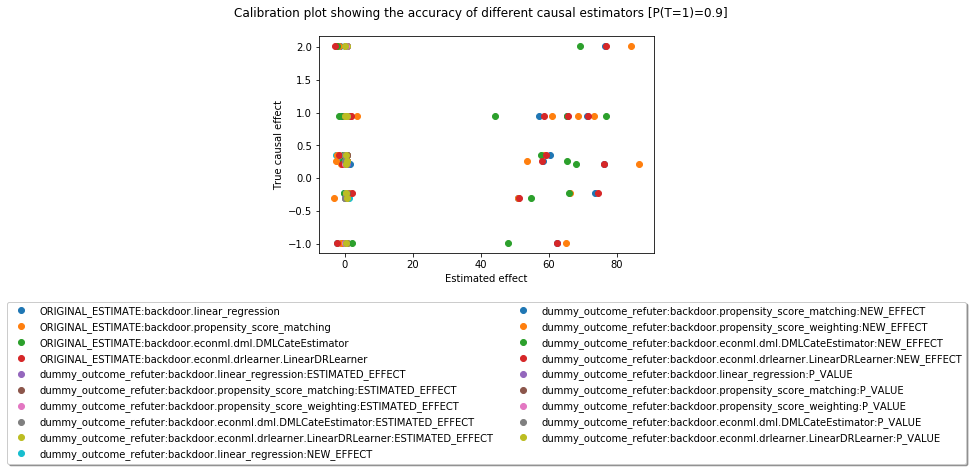

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 66.29996300588297
ORIGINAL_ESTIMATE:backdoor.econml.drlearner.LinearDRLearner 64.90768977613254
ORIGINAL_ESTIMATE:backdoor.linear_regression 64.70542034179606
ORIGINAL_ESTIMATE:backdoor.econml.dml.DMLCateEstimator 61.03758194618301
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 1.9182341142016455
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 1.5800078751574085
dummy_outcome_refuter:backdoor.econml.dml.DMLCateEstimator:NEW_EFFECT 1.4636888481817452
dummy_outcome_refuter:backdoor.econml.drlearner.LinearDRLearner:NEW_EFFECT 1.4406859637077851
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 0.9092010613327988
dummy_outcome_refuter:backdoor.econml.drlearner.LinearDRLearner:P_VALUE 0.6731030132376716
dummy_outcome_refuter:backdoor.econml.dml.DMLCateEstimator:P_VALUE 0.6583844406099305
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT

In [10]:
#PLOT
#This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator. 
plot_MAEs(res)


### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. LinearRegression 
3. LinearDRLearner 
4. Propensity Score Matching 

In [11]:
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.econml.dml.DMLCateEstimator",
                  "backdoor.econml.drlearner.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]

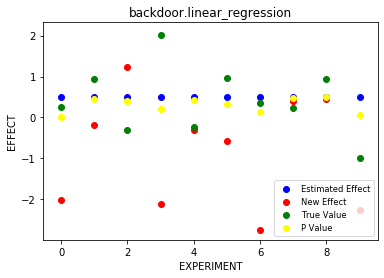

-8.142771151848216


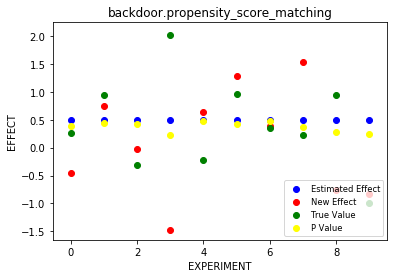

1.031906093897928


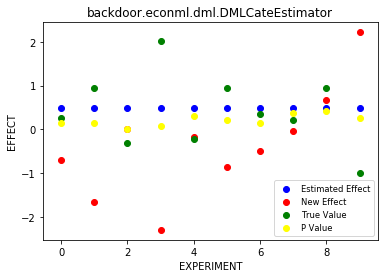

-3.3214529798294614


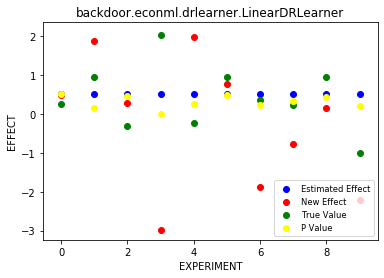

-2.346169961701663


<Figure size 432x288 with 0 Axes>

In [12]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value 
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

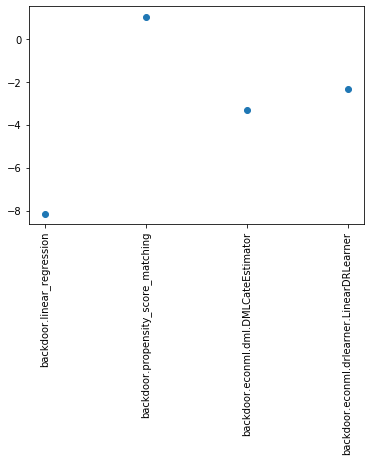

backdoor.linear_regression: -8.142771151848216
backdoor.propensity_score_matching: 1.031906093897928
backdoor.econml.dml.DMLCateEstimator: -3.3214529798294614
backdoor.econml.drlearner.LinearDRLearner: -2.346169961701663


In [13]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [14]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}


{'backdoor.propensity_score_matching': 1.031906093897928,
 'backdoor.econml.drlearner.LinearDRLearner': -2.346169961701663,
 'backdoor.econml.dml.DMLCateEstimator': -3.3214529798294614,
 'backdoor.linear_regression': -8.142771151848216}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. Propensity Score Matching 
2. Linear DR Learner 
3. DML CATE Estimator 
4. Linear Regression

Clearly, the observed unmodelled confounding error is not able to match the ranking based on the Original Estimate. It is not even able to tell that the clear winner amongst the methods according to the true value is DML CATE Estimator 

## Unobserved confounding error

For each estimator, we now simulate unobserved confounders and check its effect using dummy outcome refuter to check the unobserved confounding error for each estimator. That is, we run the refutation test for each estimator not only on the observed confounder, but also on an unobserved confounder that we simulate using the AddUnobservedCommonCause class and analyse whether there is a strong confounder that is unobserved (missing) and needs to be accounted for. 

In [15]:
unobserved_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='1',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = True
)

# Run the experiment
csv_unobserved_confounding_error = unobserved_confounding_error.experiment()
res = process_output(csv_unobserved_confounding_error)


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['t1'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountere



Running Experiment: Test_1


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.84145084],
       [ 1.31638089],
       [ 0.17910165],
       [ 1.39178526],
       [ 1.81176134],
       [-0.88180984]]), 'confounder=>outcome': array([[ 9.77143631e+01],
       [-1.45809342e-01],
       [ 6.03951728e-02],
       [ 1.83675079e+00],
       [ 1.39646149e+00],
       [-1.08805533e+00]]), 'effect_modifier=>outcome': array([[-1.49448719],
       [ 0.72905389]]), 'treatment=>outcome': array([[-0.99436025]])}
        bias: {'confounder=>treatment': array([2.22143608]), 'confounder=>outcome': array([-0.90304545])}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [59.343652333160854, 66.09709612459251, 60.45793709851523, 45.43659748496085, 59.50354970833963]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_

INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -566.816701
1     -1813.466063
2     -2477.234402
3       899.039527
4      1078.544517
          ...     
995   -2657.857241
996   -2303.389924
997     597.630070
998    2957.889077
999    -671.039102
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d99232d0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -566.764023
1     -1813.827310
2     -2477.066408
3       897.992155
4      1080.858343
          ...     
995   -2658.487327
996   -2304.981854
997     598.402869
998    2959.067697
999    -668.526932
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d8e0c590>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -569.266031
1     -1812.089639
2     -2476.759068
3       898.617948
4      1082.069208
          ...     
995   -2659.443787
996   -2301.543575
997     598.470946
998    2957.486738
999    -672.290888
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9926650>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -568.057053
1     -1812.391951
2     -2477.077501
3       899.148681
4      1078.412548
          ...     
995   -2657.728401
996   -2301.679084
997     596.080256
998    2961.037704
999    -672.243190
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6da0284d0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -567.945422
1     -1813.022662
2     -2479.018084
3       899.127020
4      1079.807598
          ...     
995   -2656.476090
996   -2303.832255
997     598.673161
998    2959.754983
999    -670.546618
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [7.130655783976482, 12.54401005781107, 9.771366959702993, 14.214171316643316, 7.2188103790485245]
p_value [0.3259972867489074, 0.05395398539275821, 0.2428089034440683, 0.21541730308567608, 0.03435872900951138]
true value -1.1656462335662459


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.30212013],
       [ 0.68199576],
       [-0.36110026],
       [ 1.24580876],
       [ 1.0965492 ],
       [-1.34345264]]), 'confounder=>outcome': array([[102.8070347 ],
       [  2.43454203],
       [ -1.67814844],
       [  1.20245975],
       [ -1.04743821],
       [  1.78403717]]), 'effect_modifier=>

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.57000478957269, 62.54498298032164, 59.80343642259743, 49.38523784228119, 60.47141375498597]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -567.945422
1     -1813.022662
2     -2479.018084
3  

INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1447.614052
1       497.673670
2      2067.952950
3     -1146.830921
4      -300.096476
          ...     
995   -2014.999901
996     142.826541
997    2255.141528
998     595.232595
999    -605.880777
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9710d50>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1446.916855
1       497.192029
2      2068.405873
3     -1147.200405
4      -300.134437
          ...     
995   -2014.395285
996     143.202542
997    2254.873644
998     593.860901
999    -607.907948
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d91ad150>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1448.083881
1       497.755201
2      2065.965931
3     -1146.552553
4      -299.494708
          ...     
995   -2015.418214
996     141.783669
997    2254.952889
998     594.746720
999    -605.396263
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d888c290>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1447.197303
1       497.657819
2      2068.771810
3     -1145.902360
4      -299.361922
          ...     
995   -2015.652791
996     142.048422
997    2254.911573
998     593.050456
999    -605.715172
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d991a0d0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1447.574320
1       499.272041
2      2065.869722
3     -1146.125003
4      -300.543760
          ...     
995   -2016.663068
996     142.945715
997    2252.878985
998     593.916424
999    -606.642650
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [7.268804162542219, 4.385561487356392, 2.53276949583685, 1.6875389974302379e-15, 1.588940288817041]
p_value [0.20584381587918132, 0.3927358766708395, 0.4029241498262466, 0.0, 0.452791826633576]
true value -0.5624467734987528


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.01357423e+02],
       [ 6.20845048e-02],
       [ 9.82327041e-01],
       [-1.32791955e+00],
       [ 5.14049699e-01],
       [-2.32209642e-01]]), 'confounder=>outcome': array([[99.5722073 ],
       [ 0.32245814],
       [-0.14263921],
       [-0.62518498],
       [-1.00203311],
       [ 0.36665454]]), 'effect_modifier

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.8665743461462, 65.92302007540067, 60.14036389911564, 52.13380834778154, 61.83521235510116]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1447.574320
1       499.272041
2      2065.869722
3     -1146.125003
4      -300.543760
          ...     
995   -2016.663068
996     142.945715
997    2252.878985
998     593.916424
999    -606.642650
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d990ee90>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0       787.093266
1      -466.715239
2     -1816.818856
3     -2881.161885
4     -1307.995121
          ...     
995    1662.755196
996     412.599566
997     273.497694
998   -1905.419194
999    1761.232512
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d894c850>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0       785.747238
1      -467.026717
2     -1819.229894
3     -2882.318815
4     -1310.535747
          ...     
995    1663.817324
996     411.165099
997     276.181774
998   -1906.667689
999    1764.334359
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6f6002990>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0       786.310053
1      -468.567458
2     -1816.278653
3     -2882.042814
4     -1308.852409
          ...     
995    1660.924174
996     410.464413
997     273.892731
998   -1906.117414
999    1762.000401
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d97c9dd0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0       787.900605
1      -466.322804
2     -1816.669646
3     -2882.553693
4     -1309.032842
          ...     
995    1663.360881
996     411.340702
997     274.315792
998   -1907.951258
999    1761.097965
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d8e0c690>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0       788.194903
1      -468.245871
2     -1815.600066
3     -2881.632717
4     -1309.326563
          ...     
995    1662.936076
996     411.372629
997     276.213694
998   -1905.812101
999    1762.442486
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [11.210590726731954, 10.485165348978175, 10.319208716254474, 3.9091713778829726, 8.353895403612581]
p_value [0.17799573442617306, 0.22384251663438443, 0.03861909280098243, 0.3651692298507274, 0.20161097836147496]
true value 0.2085791082472989


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.04557999],
       [  0.84516299],
       [  0.13293571],
       [  0.32129126],
       [ -1.70913811],
       [  0.23080566]]), 'confounder=>outcome': array([[99.33617224],
       [-0.24637577],
       [ 1.13958105],
       [ 1.57966184],
       [ 1.1764563 ],
       [-0.51130635]]), 'effect_modifier

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [66.5874553970128, 76.74234338945348, 69.04952294891127, 58.266597181065215, 66.53124061351137]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0       788.194903
1      -468.245871
2     -1815.600066
3     -2881.632717
4     -1309.326563
          ...     
995    1662.936076
996     411.372629
997     276.213694
998   -1905.812101
999    1762.442486
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9ead510>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1987.711260
1      -113.878606
2      -484.083578
3      -934.365913
4       386.361764
          ...     
995    -745.453679
996   -2265.871514
997    -621.299775
998     404.392653
999   -2048.272203
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6da01dd90>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1983.817366
1      -114.410827
2      -485.547472
3      -935.253257
4       387.056291
          ...     
995    -744.661937
996   -2264.114773
997    -620.882612
998     403.000853
999   -2046.971338
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6da00d0d0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1986.077243
1      -110.844328
2      -482.417615
3      -934.782145
4       387.549341
          ...     
995    -745.236271
996   -2265.690575
997    -620.750921
998     404.946589
999   -2049.091019
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9e7f350>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1986.463823
1      -113.861200
2      -483.346368
3      -934.987901
4       386.336768
          ...     
995    -744.991848
996   -2267.992455
997    -619.779042
998     405.828479
999   -2046.736993
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d89dd850>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1985.027393
1      -112.136416
2      -481.795571
3      -936.489651
4       385.703818
          ...     
995    -744.789563
996   -2264.641852
997    -619.922063
998     405.021178
999   -2048.140387
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [9.817666940371836, 17.994014764610323, 9.123219812116094, 0.6627527106999693, 8.257940308886013]
p_value [0.09762896759508605, 0.019774764671927007, 0.08418355426270346, 0.4942205671204525, 0.07150986339112204]
true value -0.022725834570845756


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[1.00682808e+02],
       [1.28981269e-01],
       [1.18050640e+00],
       [1.79691221e-02],
       [2.64341140e-01],
       [1.09251413e+00]]), 'confounder=>outcome': array([[98.72616387],
       [ 1.53117223],
       [ 0.55825529],
       [-0.19961281],
       [ 0.98461386],
       [-1.02116603]]), 'e

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [50.23078416258169, 42.50804401708451, 50.18006788091985, 51.89632791160171, 50.47456813994908]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      1985.027393
1      -112.136416
2      -481.795571
3      -936.489651
4       385.703818
          ...     
995    -744.789563
996   -2264.641852
997    -619.922063
998     405.021178
999   -2048.140387
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6da01eb50>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0        15.313982
1     -1769.389456
2       580.876170
3     -2561.218775
4     -1849.111042
          ...     
995    2667.880488
996    2948.579385
997    1423.050302
998   -1539.831877
999    3033.125730
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d991f6d0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0        13.122722
1     -1769.860736
2       579.692181
3     -2562.288810
4     -1847.913703
          ...     
995    2665.821608
996    2946.519679
997    1423.255174
998   -1540.718436
999    3032.438871
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d97ac350>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0        14.949792
1     -1769.261209
2       581.022641
3     -2560.554058
4     -1847.329847
          ...     
995    2665.943268
996    2948.689979
997    1422.171389
998   -1539.265890
999    3031.843547
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d97b6c10>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0        14.356055
1     -1769.974332
2       579.886963
3     -2561.728361
4     -1847.367865
          ...     
995    2665.720778
996    2946.841285
997    1422.844105
998   -1539.993792
999    3032.172059
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d7f4d290>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0        15.771926
1     -1770.662680
2       579.731204
3     -2562.007734
4     -1846.962813
          ...     
995    2666.698463
996    2948.442717
997    1422.841341
998   -1537.700224
999    3033.259906
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [4.3236225124611, 7.036657875592416, 2.623474289857397, 12.963127070655693, 9.943904162820619]
p_value [0.3567951228099353, 0.2582504323747139, 0.40092264234042363, 0.1262944703964209, 0.021513229839792255]
true value 0.22538139331211654


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.21164376],
       [ -2.19799544],
       [ -1.99627837],
       [  1.38515449],
       [ -0.14841559],
       [ -0.29276569]]), 'confounder=>outcome': array([[98.86206683],
       [-1.00222643],
       [ 1.1099932 ],
       [ 0.51500276],
       [-0.66205562],
       [ 0.76133921]]), 'effect_modifier=>out

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [70.2765851406549, 72.24655023270317, 69.86286851392508, 66.54575552674491, 70.50339523607305]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0        15.771926
1     -1770.662680
2       579.731204
3     -2562.007734
4     -1846.962813
          ...     
995    2666.698463
996    2948.442717
997    1422.841341
998   -1537.700224
999    3033.259906
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6ed94f5d0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2511.301893
1        45.497451
2      -434.147470
3      1833.307882
4      1496.631258
          ...     
995     101.254033
996     334.959689
997    1537.049900
998    -605.082738
999    -776.574523
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9923550>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2510.354969
1        49.316480
2      -434.426661
3      1833.901609
4      1498.220687
          ...     
995     101.819316
996     334.778166
997    1537.089747
998    -604.314946
999    -776.859184
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9923950>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2510.881103
1        45.788209
2      -434.090848
3      1833.752678
4      1495.689672
          ...     
995     101.519241
996     333.904056
997    1535.608816
998    -606.617944
999    -779.540353
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d88bca10>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2509.431536
1        48.092526
2      -433.265148
3      1832.220091
4      1498.021536
          ...     
995     103.101970
996     334.318335
997    1537.650332
998    -605.820835
999    -777.776612
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d919eb50>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2512.445152
1        47.443399
2      -433.425420
3      1832.607359
4      1498.362483
          ...     
995     102.260523
996     334.813321
997    1538.464082
998    -605.569111
999    -776.793063
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [6.074315478976711, 7.449595313496745, 10.654988725350156, -0.7221545197533958, 9.727457316414087]
p_value [0.19883644909915127, 0.31728679242956515, 0.09004361782172376, 0.19872441215338288, 0.22093189461603874]
true value -0.8304542577664819


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.67900469],
       [ -0.21441125],
       [ -0.30076325],
       [  1.01355676],
       [ -0.5632018 ],
       [ -0.16790986]]), 'confounder=>outcome': array([[98.22367573],
       [ 0.60376231],
       [ 2.61369616],
       [-0.36707636],
       [-0.84234516],
       [ 2.40963927]]), 'effect_modifie

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [68.12089974029084, 67.38436581484089, 67.9797769134544, 64.3394630515909, 67.89892110857701]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2512.445152
1        47.443399
2      -433.425420
3      1832.607359
4      1498.362483
          ...     
995     102.260523
996     334.813321
997    1538.464082
998    -605.569111
999    -776.793063
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9928950>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -952.215952
1       772.455433
2      2325.430419
3     -1933.708251
4       976.016525
          ...     
995   -1720.602677
996   -1381.663943
997   -1566.937451
998     413.355397
999   -3225.021032
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d919eb50>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -951.585277
1       772.296005
2      2327.648244
3     -1933.365819
4       975.470274
          ...     
995   -1719.687705
996   -1381.001755
997   -1567.403691
998     411.067867
999   -3224.874356
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9705310>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -951.020559
1       772.064340
2      2323.823426
3     -1932.556375
4       974.105459
          ...     
995   -1721.017353
996   -1380.749633
997   -1569.065338
998     411.715294
999   -3223.944731
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6f68515d0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -951.921978
1       772.829161
2      2326.240377
3     -1934.469218
4       975.401502
          ...     
995   -1719.650772
996   -1381.088296
997   -1569.029050
998     413.617979
999   -3226.468878
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d88bca10>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -950.544558
1       771.436650
2      2326.302327
3     -1933.909673
4       975.782971
          ...     
995   -1719.746388
996   -1380.862017
997   -1568.127403
998     412.839446
999   -3226.480518
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [11.535000534728699, 10.556330190925078, 5.983927847291993, 4.585311122225076, 5.521106390996527]
p_value [0.15763994528045255, 0.11257106474752443, 0.2040099625182959, 0.2718808657981042, 0.19768734518934916]
true value 0.05259178177349041


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.69725841],
       [  1.09209949],
       [ -0.44861404],
       [ -0.18163234],
       [  0.23641146],
       [ -0.81695054]]), 'confounder=>outcome': array([[99.55908256],
       [-1.53102599],
       [ 0.20373259],
       [ 0.82797327],
       [-0.91967044],
       [ 0.40162594]]), 'effect_modifier=>

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be inval

printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [65.00015742286487, 61.34246539089605, 64.74120930988474, 65.63026252842393, 64.8801538533795]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0      -950.544558
1       771.436650
2      2326.302327
3   

INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1333.190959
1       721.621044
2        15.659552
3       438.224830
4       413.869059
          ...     
995   -3136.319127
996   -2152.715592
997     -18.395705
998    1854.865366
999   -2076.987505
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d7e98090>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1331.369042
1       721.346602
2        14.129119
3       440.257108
4       413.118955
          ...     
995   -3134.308387
996   -2153.850842
997     -18.605334
998    1855.140916
999   -2075.662284
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6da01ed90>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1331.933602
1       718.645750
2        16.066056
3       438.088414
4       410.522059
          ...     
995   -3135.089132
996   -2152.882948
997     -18.361019
998    1855.193900
999   -2076.200314
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6f6180e90>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1332.719881
1       719.917036
2        13.983546
3       439.066218
4       411.803042
          ...     
995   -3133.596167
996   -2153.871402
997     -20.620698
998    1855.713640
999   -2076.014261
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d8dcdd90>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1333.484379
1       720.232517
2        15.276714
3       439.554576
4       410.963279
          ...     
995   -3134.252937
996   -2153.712155
997     -19.627142
998    1855.865680
999   -2075.564824
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.16508676041878373, 1.3368491300274248, -1.6346864709942195, 5.721781304191974, 9.435492729258907]
p_value [0.4636483486084929, 0.44921816232486234, 0.4336772017898779, 0.3359472337512906, 0.03412241253589131]
true value 1.1819305954542763


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.63209496],
       [ -1.15506034],
       [  2.54416446],
       [  0.4605843 ],
       [  1.13637209],
       [ -0.6189154 ]]), 'confounder=>outcome': array([[ 9.84848940e+01],
       [-7.81605858e-01],
       [ 1.19231696e-02],
       [ 9.52048402e-01],
       [ 3.69647630e-01],
       [ 7.32907887e

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [74.33806914270644, 67.86513062153139, 73.97529015665663, 71.38497287737252, 74.41880331825904]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1333.484379
1       720.232517
2        15.276714
3       439.554576
4       410.963279
          ...     
995   -3134.252937
996   -2153.712155
997     -19.627142
998    1855.865680
999   -2075.564824
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d8e83b10>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2187.146529
1     -1804.369092
2       746.529274
3      2008.354518
4      -586.454218
          ...     
995    -580.855482
996    2971.254080
997   -1694.128644
998     397.337962
999   -1859.306557
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6f2031f50>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2187.425173
1     -1803.989042
2       747.024958
3      2008.937480
4      -585.905336
          ...     
995    -584.438644
996    2972.043362
997   -1695.558475
998     397.267285
999   -1860.481958
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6f6851b50>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2187.677728
1     -1802.737846
2       745.601758
3      2006.946638
4      -587.412310
          ...     
995    -582.503911
996    2971.628237
997   -1695.357001
998     395.574211
999   -1857.933579
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6f6002ed0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2187.761103
1     -1802.958065
2       746.080374
3      2008.525171
4      -586.785452
          ...     
995    -584.755602
996    2971.615742
997   -1695.641532
998     394.681579
999   -1858.080903
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d8881250>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2187.488152
1     -1804.374242
2       748.559127
3      2005.973670
4      -587.954880
          ...     
995    -583.147090
996    2971.469381
997   -1693.873551
998     396.117323
999   -1857.170929
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [12.768294682270527, 7.154385743115986, 11.888969494778078, 4.129128160767726, 12.217849507104166]
p_value [0.04494789975521878, 0.2300836689508572, 8.976414192995711e-06, 0.3076314564988524, 0.059049881966816514]
true value 0.6625398397521289


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.00265294e+02],
       [-6.38633020e-02],
       [ 5.82455605e-01],
       [-1.17546321e+00],
       [ 2.65239770e+00],
       [ 9.18395746e-01]]), 'confounder=>outcome': array([[100.40557072],
       [  0.63061129],
       [ -0.62029287],
       [ -0.22876141],
       [  0.56591469],
       [  0.9426

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DMLCateEstimator', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DMLCateEstimator'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w2+w3+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [54.22740971021551, 46.10508654609161, 52.73674123342644, 53.66115030552041, 53.75121562156154]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -2187.488152
1     -1804.374242
2       748.559127
3      2005.973670
4      -587.954880
          ...     
995    -583.147090
996    2971.469381
997   -1693.873551
998     396.117323
999   -1857.170929
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d7f63050>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1842.261179
1      -917.019629
2      -380.630998
3       116.353643
4      -636.940221
          ...     
995   -3118.804273
996   -4713.432402
997   -1330.434496
998    2673.010119
999    -524.296310
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
INFO:dowhy.caus

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d96e66d0>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1842.221788
1      -916.181163
2      -378.885866
3       113.970187
4      -637.513168
          ...     
995   -3119.129298
996   -4716.143131
997   -1330.821954
998    2672.357846
999    -523.481015
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d991f190>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1845.192288
1      -916.571186
2      -379.554195
3       114.727731
4      -637.793666
          ...     
995   -3117.839139
996   -4714.605288
997   -1330.530493
998    2672.928883
999    -523.509467
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A col

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d9922850>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1843.958212
1      -915.515428
2      -378.282148
3       117.063210
4      -638.142916
          ...     
995   -3118.265103
996   -4713.986691
997   -1331.184558
998    2672.749560
999    -522.420026
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/econml/dml.py:163: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb6d96e6050>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb6f676a5f0>, 'unobserved_confounder_values': 0     -1843.273212
1      -914.841361
2      -379.456023
3       114.721057
4      -637.133318
          ...     
995   -3120.017086
996   -4713.116982
997   -1330.583714
998    2672.624910
999    -524.498412
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w2+w3+x1+x2 | x1,x2
/opt/anaconda3/lib/python3.7/site-packages/econml/utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-vari

printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [17.349686899741982, 5.365694373825282, -1.6158533536968953, -2.5580418650126875, 23.94885808207112]
p_value [3.0145833395079844e-06, 0.333623961785957, 0.35289772088990035, 0.35345808544973956, 0.00036274877659173095]
true value -0.6348550311907358


Completed all experiments. Saving the data...
Data has been saved in  results/Test_1_2020-12-24 08:28:07.579556_data.csv


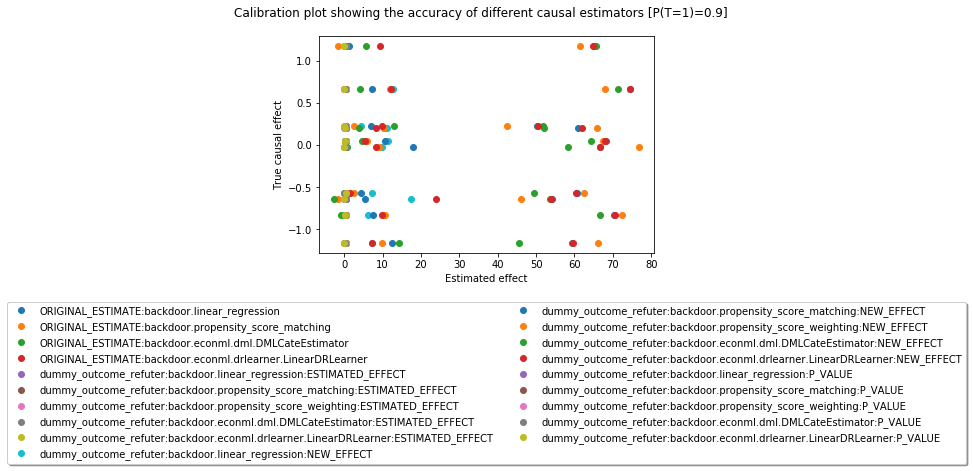

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.econml.drlearner.LinearDRLearner 63.115357912179114
ORIGINAL_ESTIMATE:backdoor.linear_regression 63.04466975972607
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 62.96441906049697
ORIGINAL_ESTIMATE:backdoor.econml.dml.DMLCateEstimator 57.956527846939686
dummy_outcome_refuter:backdoor.econml.drlearner.LinearDRLearner:NEW_EFFECT 9.709935998108335
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 9.08926910851826
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 8.519336969779264
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 6.812772170645998
dummy_outcome_refuter:backdoor.econml.dml.DMLCateEstimator:NEW_EFFECT 4.763672575799831
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 0.7574046282466561
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 0.7574046282466561
dummy_outcome_refuter:backdoor.propensity_score_weighting:ESTIMATED_

In [16]:
##This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator.
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. Propensity Score Matching 
3. LinearRegression 
4. LinearDRLearner 

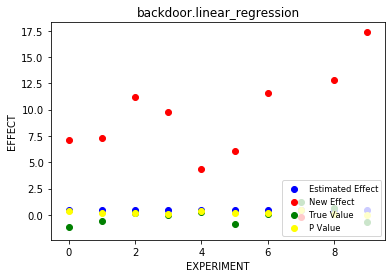

87.31355096138272


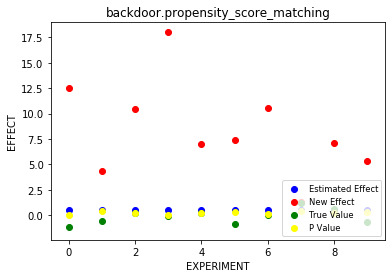

84.30826428573889


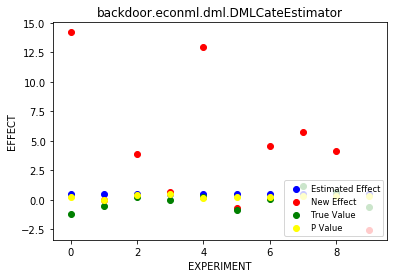

42.90524667830064


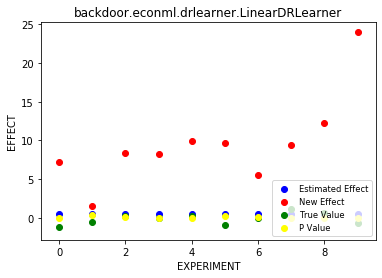

96.21425456902959


<Figure size 432x288 with 0 Axes>

In [17]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

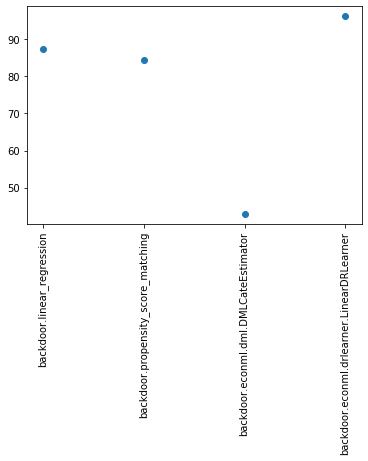

backdoor.linear_regression: 87.31355096138272
backdoor.propensity_score_matching: 84.30826428573889
backdoor.econml.dml.DMLCateEstimator: 42.90524667830064
backdoor.econml.drlearner.LinearDRLearner: 96.21425456902959


In [18]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [19]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}

{'backdoor.econml.drlearner.LinearDRLearner': 96.21425456902959,
 'backdoor.linear_regression': 87.31355096138272,
 'backdoor.propensity_score_matching': 84.30826428573889,
 'backdoor.econml.dml.DMLCateEstimator': 42.90524667830064}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. DML CATE Estimator 
2. Propensity Score Matching 
3. Linear Regression
4. Linear DR Learner 

#### We can see that this ranking is exactly the same as the one based on Original Estimate. Thus ranking based on the unobserved confounding error solves the problem and gives us a correct ranking amongst methods